# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

%autosave 0

Autosave disabled


Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 49 s, sys: 180 ms, total: 49.2 s
Wall time: 49.7 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,28
organization,25
article,42
codes,148
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [10]:
codingOrder = pd.DataFrame({'article': [
    'swana-population-map',
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-school-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    '2018-voter-registration',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [11]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,18,california-ccscore-analysis,"[format table display, read as tabular data, s...",0,23,"export results, group by single column, change..."
1,7,2019-04-democratic-candidate-codonors,"[use open government data, read as tabular dat...",1,43,"trim by contains value, group by multiple colu..."
2,19,california-crop-production-wages-analysis,"[use open government data, format table displa...",3,50,"construct table manually, architect repeating ..."
3,21,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",4,52,"slice column values, tolerate dirty data"
4,31,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,63,"perform entity resolution manually, fill in na..."


Plot the size of the code set as more computational notebooks are analyzed.

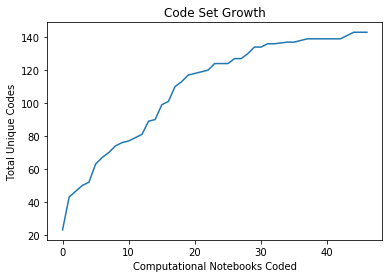

In [12]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [13]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: export results, group by single column, change column data type, trim by date range, create a crosstab, calculate percentage difference, calculate z-score, repetitive code, inspect table schema, calculate difference, sort table, count number of rows, count value frequency, format table display, outer join tables, calculate mean, drop duplicate rows based on values, read as tabular data, split, compute, and merge, subset columns, visualize data, peek at data, trim by quantitative threshold

2. **2019-04-democratic-candidate-codonors**: trim by contains value, group by multiple columns, self join table, canonicalize column names, calculate ratio, count unique values in column, strip whitespace, annotate workflow, architect a subroutine, drop duplicate rows based on prior knowledge, use open government data, remove with regular expression, change case, compare different groups along a common metric, sum along dimension, gather table, union tables, create a semi-unique key, export intermediate results, calculate scaled ratio

3. **california-crop-production-wages-analysis**: construct table manually, architect repeating process, answer a question, wrangle data for graphics, trim by geographic area, inner join tables, adjust for inflation

4. **census-hard-to-map-analysis**: slice column values, tolerate dirty data

5. **long-term-care-db**: perform entity resolution manually, fill in na values after an outer join, join with lookup table, use non-public, provided data, encode table identification in row, scrape web for data, aggregate the forest from the trees, refine table, fix data errors manually, drop erroneous rows, construct pivot table

6. **2018-voter-registration**: show trend over time, calculate a statistic, pull tables out of pdf, create rolling window

7. **heat_and_humidity**: generate data computationally, cartesian product, compute index number

8. **2016-11-bellwether-counties**: spread table, get extreme values, use academic data, remove incomplete data

9. **2018-05-31-crime-and-heat-analysis**: extract property from datetime, combine seemingly disparate datasets

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: wtf, use public data

12. **2016-04-republican-donor-movements**: explore dynamic network flow, split column on delimiter

13. **california-h2a-visas-analysis**: geocode addresses, create child table, split and compute, cache results from external service, preserve existing values, temporary joining column, create a unique key, replace na values

14. **Endangered-Species-Act-Louisiana**: transform vector

15. **Power_of_Irma**: toggle step on and off, interpret statistical/ml model, fix incorrect calculation, change date format, value replacement, set data confidence threshold, use data from colleague, outlier detection, use previously cleaned data

16. **wikipedia-rankings**: explain variance, collect raw data

17. **babyname_politics**: assign ranks, break ties, round floating point, check results of previous operation, concatenate columns into key, data loss from aggregation, join aggregate, resort after merge, get unique values

18. **2015-11-refugees-in-the-united-states**: make an incorrect conclusion, designate column as primary key, test for equality

19. **employment-discrimination**: combine entities by string matching, align table columns for consolidation, concatenate files together, merge tables to create pivot table

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: copy table schema, translate entity names manually, data too large for repo, create flag

24. **buster-posey-mvp**: 

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: correct bad formatting, report rows with column number discrepancies, sort table rows

27. **prison-admissions**: 

28. **school-star-ratings-2018**: display rows with missing values, pad column values, reconcile primary keys between tables

29. **electric-car-charging-points**: encode redundant information, define edge weights, find nearest neighbours in the network, create edge

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality, freedom of information data

32. **librarians**: 

33. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices

34. **2018-voter-registration**: 

35. **2019-ems-analysis**: combine data and geography

36. **auditData**: combine columns

37. **lending-club**: 

38. **skatemusic**: 

39. **201901-hospitalquality**: 

40. **general-election-2015-classification-tree**: wrangle data for model, check for nas

41. **201901-achievementgap**: bin values, query database

42. **school-choice**: 

43. **swana-population-map**: 